In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR

In [2]:
#Import the Dataset from txt files
colnames = ["time/s\t", "current/A\t", "potential/V"]

path = r'C:\Users\Sebastian\Documents\RWTH\IDS\Aufgaben\py_challenges\01_challenge\01-data\80CO2_20CO' # use your path
all_files = glob.glob(path + "/*.txt")

li = []

#Loop which takes all files in the path and imports them
for filename in all_files:
    naming = filename.split() #take the filename and split all parts it into a list
    naming_temp = naming[1] #Temperature is the second part in the list, since lists start at 0 it is 1
    naming_co = naming[4]
    naming_co2 = naming[2]
    df = pd.read_csv(filename, index_col=None,sep='\s+', names = colnames, skiprows = 1, dtype = np.float64)
    df["T/°C"] = naming_temp
    df["CO2/%"] = naming_co2
    df["CO/%"] = naming_co
    li.append(df)

df8020 = pd.concat(li, axis=0, ignore_index=True)

path = r'C:\Users\Sebastian\Documents\RWTH\IDS\Aufgaben\py_challenges\01_challenge\01-data\50CO2_50CO' # use your path
all_files = glob.glob(path + "/*.txt")

li = []

for filename in all_files:
    naming = filename.split()
    naming_temp = naming[1]
    naming_co = naming[4]
    naming_co2 = naming[2]
    df = pd.read_csv(filename, index_col=None,sep='\s+', names = colnames, skiprows = 1, dtype = np.float64) 
    df["T/°C"] = naming_temp
    df["CO2/%"] = naming_co2
    df["CO/%"] = naming_co
    li.append(df)

df5050 = pd.concat(li, axis=0, ignore_index=True)

In [3]:
#compute the current density for each of the dataframe
df5050["current_density"] = df5050["current/A\t"] / 0.785
df8020["current_density"] = df8020["current/A\t"] / 0.785

#Build a combined dataframe by appending df8020 to df5050
combined_df = df5050.append(df8020)

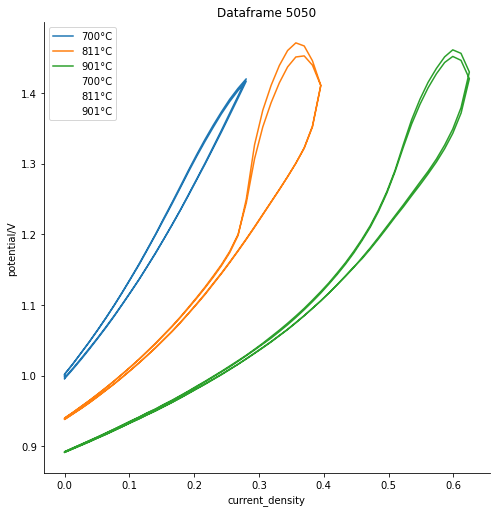

In [5]:
#Plot for Df5050 as specified in the readme
g = sns.FacetGrid(df5050, hue="T/°C", height=7)
g.map(plt.scatter, "current_density", "potential/V", s=0)
g.map(plt.plot, "current_density", "potential/V")
plt.title("Dataframe 5050")
plt.legend()

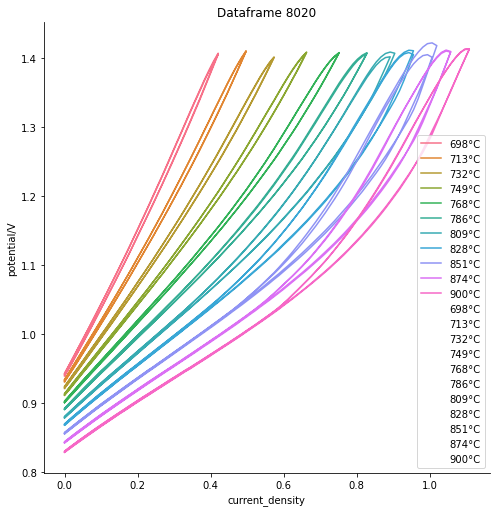

In [6]:
#Plot for Df8020 as specified in the readme
g = sns.FacetGrid(df8020, hue="T/°C", height=7)
g.map(plt.scatter, "current_density", "potential/V", s =0)
g.map(plt.plot, "current_density", "potential/V")
plt.title("Dataframe 8020")
plt.legend()

In [8]:
#start to build the final dataframe as specified in the readme
final_df = pd.DataFrame()
final_df["T/°C"] = combined_df['T/°C'].unique() #copy the temperatures from combined_df
arr = [] #empty arrays to fill with the calculated/extracted values to later append to the final_df
arr2 = []

#in the following we take the temperature to iterate over since those are unique values
for temp in combined_df['T/°C'].unique():
    val = int(combined_df[combined_df['T/°C'] == temp]["CO2/%"].unique()[0])
    val2 = int(combined_df[combined_df['T/°C'] == temp]["CO/%"].unique()[0])
    arr.append(val)
    arr2.append(val2)
    
final_df["CO2/%"] = arr
final_df["CO/%"] = arr2

In [12]:
i100 = np.logical_and(combined_df[combined_df['T/°C'] == temp].loc[:,'current_density'] < 0.12, 
                          combined_df[combined_df['T/°C'] == temp].loc[:,'current_density'] > 0.08)
print(i100)

0      False
1      False
2      False
3      False
4      False
       ...  
103    False
104    False
105    False
106    False
107    False
Name: current_density, Length: 108, dtype: bool


In [22]:
#Determine the Open Circuit Voltage (OCV): this is the potential, where the current is 0 (taking mean of the Potential (V) values closest to y=0)
#Determine the Area Specific Resistance (ARS): Calculate the slopes at 100mA
#determine the current density at 1.4 V
lr = LR() # instantiate linear regression to calculate ARS

arr = []
arr1 = []
arr2 = []
for temp in combined_df['T/°C'].unique():
    pot = (combined_df[(combined_df["current_density"] == min(combined_df[combined_df['T/°C'] == temp].loc[:,'current_density'], key=abs)) 
                      & (combined_df["T/°C"]== temp )]['potential/V'])
    
    # Calculate ARS by taking x and y values between 0.08>x<0.12 and do linear regression, get the slope
    selector = np.logical_and(combined_df[combined_df['T/°C'] == temp].loc[:,'current_density'] < 0.12, 
                          combined_df[combined_df['T/°C'] == temp].loc[:,'current_density'] > 0.08)
    x = combined_df[combined_df['T/°C'] == temp].loc[selector,'current_density']
    y = combined_df[combined_df['T/°C'] == temp].loc[selector,'potential/V']
    lr.fit(np.array(x).reshape(-1,1),np.array(y).reshape(-1,1))
    ars = float(lr.coef_)
    
    
    cdy = combined_df[(combined_df["potential/V"] == min(combined_df[combined_df['T/°C'] == temp].loc[:,'potential/V'], key=lambda x:abs(x-1.4))) 
                      & (combined_df["T/°C"]== temp )]['current_density']
    arr.append(np.mean(pot))
    arr1.append(ars)
    arr2.append(np.mean(cdy))
    
    print('\033[1m' + "For " + str(temp) + ":" '\033[0m')
    print(str(temp) + ' has OCV: ' + str(np.mean(pot)))
    print(str(temp) + ' has ARS: ' + str(ars))
    print(str(temp) + ' current density at 1.4V: ' + str(np.mean(cdy)))
    print("\n")
    
final_df["OCV/V"] = arr
final_df["ASR/ohm cm^2"] = arr1
final_df["J_1.4V/A cm^2"] = arr2

For 700°C:
700°C has OCV: 0.9985768
700°C has ARS: 1.445826876169717
700°C current density at 1.4V: 0.267487898089172


For 811°C:
811°C has OCV: 0.9383674999999998
811°C has ARS: 0.7998313944929986
811°C current density at 1.4V: 0.39529171974522287


For 901°C:
901°C has OCV: 0.8914455000000002
901°C has ARS: 0.436882382623727
901°C current density at 1.4V: 0.5608127388535031


For 698°C:
698°C has OCV: 0.9411702666666666
698°C has ARS: 1.0153308744150171
698°C current density at 1.4V: 0.4077987261146496


For 713°C:
713°C has OCV: 0.9325807142857142
713°C has ARS: 0.8664875050289583
713°C current density at 1.4V: 0.48440382165605095


For 732°C:
732°C has OCV: 0.9224320000000003
732°C has ARS: 0.7424271356705738
732°C current density at 1.4V: 0.5737108280254777


For 749°C:
749°C has OCV: 0.9123314999999999
749°C has ARS: 0.6550710182966547
749°C current density at 1.4V: 0.6501197452229298


For 768°C:
768°C has OCV: 0.9016512500000001
768°C has ARS: 0.5783094101961106
768°C current 

In [23]:
print(final_df)

     T/°C  CO2/%  CO/%     OCV/V  ASR/ohm cm^2  J_1.4V/A cm^2
0   700°C     50    50  0.998577      1.445827       0.267488
1   811°C     50    50  0.938367      0.799831       0.395292
2   901°C     50    50  0.891446      0.436882       0.560813
3   698°C     80    20  0.941170      1.015331       0.407799
4   713°C     80    20  0.932581      0.866488       0.484404
5   732°C     80    20  0.922432      0.742427       0.573711
6   749°C     80    20  0.912331      0.655071       0.650120
7   768°C     80    20  0.901651      0.578309       0.739232
8   786°C     80    20  0.891503      0.507334       0.802353
9   809°C     80    20  0.879388      0.470209       0.878957
10  828°C     80    20  0.869093      0.423134       0.917260
11  851°C     80    20  0.856421      0.391570       0.955757
12  874°C     80    20  0.843156      0.375438       1.019269
13  900°C     80    20  0.829568      0.358172       1.070469


In [18]:
#export final_df to csv as final_df.csv
final_df.to_csv(r'final_df.csv', index = False, header=True)